# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [6]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [9]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size
frames = 15    #no of images
height = 100   #height of image
width = 100    #width of image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [3]:
def generator(source_path, folder_list, batch_size):
    img_idx = rn.sample(range(30),frames) #create a list of image numbers you want to use for a particular video

    y = height
    z = width 
    while True:
        seq_batch = []
        t = np.random.permutation(folder_list)
        x = len(t)
        num_batches = x//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches

            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size

                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                seq_batch.append(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    cropped_image = resize(image, (y,z))
#                     cropped_image  = cropped_image[0:100,0:100]  #cropping image
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = cropped_image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = cropped_image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = cropped_image[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_seq_len = x%batch_size
        if rem_seq_len!=0:
            batch_data = np.zeros((rem_seq_len,len(img_idx),y,z,3))
            batch_labels = np.zeros((rem_seq_len,5))
            for folder in range(rem_seq_len): # iterate over the batch_size
            
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                seq_batch.append(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    cropped_image = resize(image, (y,z))
#                     cropped_image  = cropped_image[0:100,0:100]  #cropping image

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = cropped_image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = cropped_image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = cropped_image[:,:,2]/255#normalise and feed in the image


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_label
            
        # write the code for the remaining data points which are left after full batches

In [17]:
def plot(history):
    #plot training and validation accuracy along with training & validation loss for best model selection
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    return

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation,Conv2D, Conv3D,LSTM, MaxPooling3D,TimeDistributed, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

### Simple Conv3D + MaxPooling3D Model

In [13]:
#This model is simple Conv3D & MaxPooling3D model with less no of layers and parameters to test on training data
model = Sequential()
#added Conv3D and MaxPooling3D layer along with relu as activation function
model.add(Conv3D(16,kernel_size = (3,3,3),activation = 'relu',input_shape = (frames,100,100,3),padding = 'same'))  
model.add(MaxPooling3D(pool_size = (2,2,2), padding = 'same'))
model.add(Conv3D(32,kernel_size = (3,3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size = (2,2,2),padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))   #Added no of gestures which is 5 in this case study

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.Adam(learning_rate = 0.01) #Added Adam optimizer with learning rate = 0.01
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 64)                5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)  #calling generator to generate data in batches
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
#fitting model on training data for 20 epochs
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[LR],
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2023-06-04 12:34:50.827735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - 79s 4s/step - loss: 25.1902 - categorical_accuracy: 0.1916 - val_loss: 1.6131 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - 79s 4s/step - loss: 1.6130 - categorical_accuracy: 0.2097 - val_loss: 1.6058 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - 77s 4s/step - loss: 1.6094 - categorical_accuracy: 0.2021 - val_loss: 1.6140 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 4/20
21/21 [==============================] - 74s 4s/step - loss: 1.6098 - categorical_accuracy: 0.1946 - val_loss: 1.6086 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 5/20
21/21 [==============================] - 77s 4s/step - loss: 1.6104 - categorical_accuracy: 0.1961 - val_loss: 1.6059 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 6/20
21/21 [==============================] - 78s 4s/step - loss: 1.6099 - categorical_accuracy: 0.1976 - val_loss: 1.6

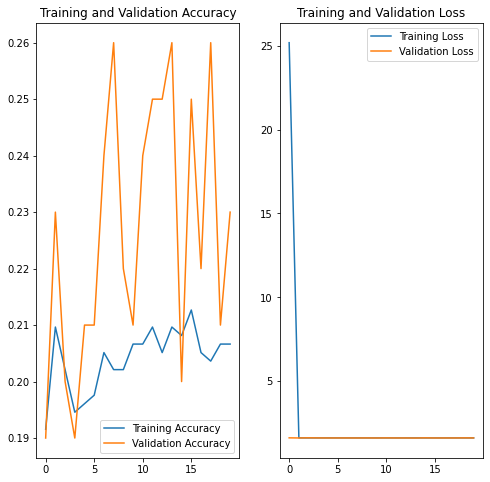

In [20]:
#plotting training & validation accuracy along with training & validation loss
plot(history)

1) The training accuracy is 20.66% and validation accuracy is 23% which resembles simple conv3d  is an underfit model which means modern is learning out of data we can  add some more layers to avoid underfitting

2) The validation loss 1.6076 which can further decreased to avoid underfitting.

### Multiple Conv3D + MaxPooling3D Model

In [21]:
#This architecture resembles multiple layers of Conv3D & MaxPooling3D along with batch normalization layer and relu activation function
model = Sequential()
model.add(Conv3D(8,kernel_size = (3,3,3),activation = 'relu',input_shape = (frames,100,100,3),padding = 'same'))
model.add(MaxPooling3D(pool_size = (2,2,2), padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #Batch Normalization layer

model.add(Conv3D(16,kernel_size = (3,3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size = (2,2,2),padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization()) #Batch Normalization layer

model.add(Conv3D(32,kernel_size = (3,3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size = (2,2,2),padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization()) #Batch Normalization layer

model.add(Conv3D(64,kernel_size = (3,3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size = (2,2,2),padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization()) #Batch Normalization layer

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))   #Added no of gestures which is 5 in this case study

In [22]:
optimiser = optimizers.Adam(learning_rate = 0.01) #Added Adam optimizer with learning rate = 0.01
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 100, 100, 8)   656       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 8, 50, 50, 8)     0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 50, 50, 8)      0         
                                                                 
 batch_normalization (BatchN  (None, 8, 50, 50, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 25, 25, 16)   

In [23]:
#fitting model on training data for 20 epochs

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[LR],
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - 80s 4s/step - loss: 1.9828 - categorical_accuracy: 0.3379 - val_loss: 394.6769 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - 77s 4s/step - loss: 1.5057 - categorical_accuracy: 0.3937 - val_loss: 256.0794 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - 78s 4s/step - loss: 1.1215 - categorical_accuracy: 0.5083 - val_loss: 113.5904 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 4/20
21/21 [==============================] - 75s 4s/step - loss: 1.0632 - categorical_accuracy: 0.5309 - val_loss: 27.1818 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 5/20
21/21 [==============================] - 76s 4s/step - loss: 1.0061 - categorical_accuracy: 0.5656 - val_loss: 5.0119 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 6/20
21/21 [==============================] - 77s 4s/step - loss: 0.9858 - categorical_accuracy: 0.589

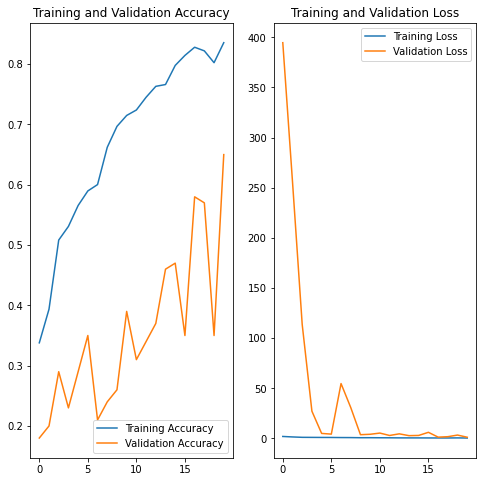

In [24]:
#Plotting training and validation accuracy along with training and validation loss
plot(history)

1) As we can see from Training and Validation Accuracy, Training accuracy came as 83.56% with validation accuracy as 65% which has removed the underfitting validation accuracy can be further improved by doing few techniques like data augmentation and training for large no of epochs.

2) As we can see from Training loss it is very close to zero but not exactly zero. As the epochs increase validation loss reached towards training loss which is around 1.19(val_loss)

### Conv2D + RNN(GRU)

In [25]:
#This architecture resembles multiple layers of Conv2D & RNN(GRU) in time distributed manner along with batch normalization layer and relu activation function
#along with this he uniform weight intialization is used
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform'),
                 input_shape=(frames,100,100,3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))


model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())  #Batch Normalization layer


model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())  #Batch Normalization layer
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())  #Batch Normalization layer
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.25))
model.add(GRU(64, return_sequences = False)) #GRU for RNN
model.add(Dense(5, activation = 'softmax'))   #Added no of gestures which is 5 in this case study

In [26]:
optimiser = optimizers.Adam(learning_rate = 0.01) #Added Adam optimizer with learning rate = 0.01
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 8)  104       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 50, 50, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   528       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 25, 25, 16)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 15, 25, 25, 16)  

In [27]:
#fitting model on training data for 20 epochs
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[LR],
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - 80s 4s/step - loss: 1.4388 - categorical_accuracy: 0.4238 - val_loss: 2.3313 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - 77s 4s/step - loss: 1.0268 - categorical_accuracy: 0.5475 - val_loss: 2.7105 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - 77s 4s/step - loss: 0.9017 - categorical_accuracy: 0.6576 - val_loss: 2.9839 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 4/20
21/21 [==============================] - 74s 4s/step - loss: 0.7551 - categorical_accuracy: 0.7059 - val_loss: 3.2278 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 5/20
21/21 [==============================] - 77s 4s/step - loss: 0.7192 - categorical_accuracy: 0.7059 - val_loss: 3.4617 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 6/20
21/21 [==============================] - ETA: 0s - loss: 0.6584 - categorical_accuracy: 0.7270
Epoch 000

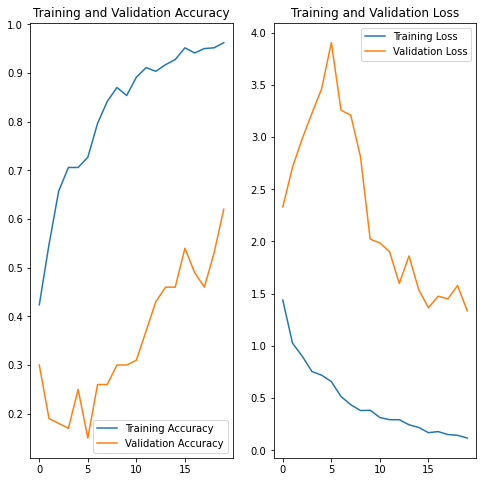

In [28]:
#plotting Training and validation accuracy along with training and validation loss
plot(history)

1) In this Conv2D , RNN (GRU) has been used in convolutiona architecture.

2) As we can see from Training and Validation Accuracy, Training accuracy came as 96.23% with validation accuracy as 62% which has removed the underfitting validation accuracy can be further improved by doing few techniques like data augmentation and training for large no of epochs.

3) As we can see from Training loss it is very close to zero but not exactly zero. As the epochs increase validation loss reached towards training loss which is around 1.33(val_loss)

Hence, if we compare Multiple Conv3D + MaxPool3D with Conv2D + RNN(GRU) , Multiple Conv3D + MaxPool3D outperforms other models(Multiple Conv3D + MaxPool3D , Conv2D + RNN(GRU)) in terms of accuracies, overfitting and underfitting.

### Conv2D + RNN(LSTM)

In [29]:
#This architecture resembles multiple layers of Conv2D & RNN(GRU) in time distributed manner along with batch normalization layer and relu activation function
#along with this he uniform weight intialization is used.
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform'),
                 input_shape=(frames,100,100,3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))


model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization()) #Batch Normalization layer


model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization()) #Batch Normalization layer
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization()) #Batch Normalization layer
model.add(Dropout(0.25))


model.add(TimeDistributed(Flatten()))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences = False))  #LSTM for RNN
model.add(Dense(5, activation = 'softmax')) #Added no of gestures which is 5 in this case study

In [30]:
optimiser = optimizers.Adam(learning_rate = 0.01) #Added Adam optimizer with learning rate = 0.01
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 100, 100, 8)  104       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 50, 50, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 50, 50, 16)   528       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 25, 25, 16)   0         
 stributed)                                                      
                                                                 
 batch_normalization_7 (Batc  (None, 15, 25, 25, 16)  

In [31]:
#fitting model on training data for 20 epochs

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[LR],
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - 81s 4s/step - loss: 1.3837 - categorical_accuracy: 0.4087 - val_loss: 2.4159 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - 77s 4s/step - loss: 1.1228 - categorical_accuracy: 0.5385 - val_loss: 2.3886 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - 77s 4s/step - loss: 0.9499 - categorical_accuracy: 0.6124 - val_loss: 3.3718 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 4/20
21/21 [==============================] - 74s 4s/step - loss: 0.8566 - categorical_accuracy: 0.6561 - val_loss: 2.5758 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 5/20
21/21 [==============================] - 77s 4s/step - loss: 0.8103 - categorical_accuracy: 0.6998 - val_loss: 2.8414 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 6/20
21/21 [==============================] - 77s 4s/step - loss: 0.6411 - categorical_accuracy: 0.7496 - val

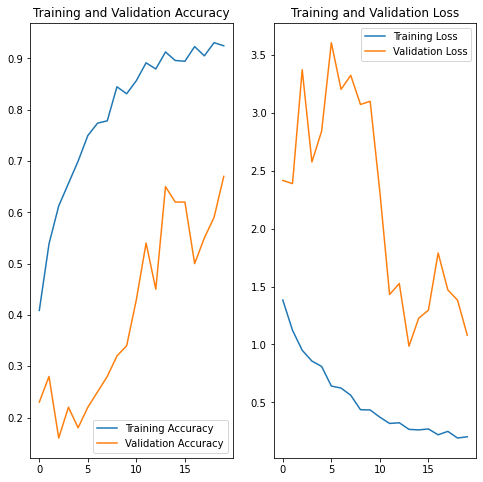

In [32]:
#plotting Training and validation accuracy along with training and validation loss

plot(history)

1) In this Conv2D , RNN (LSTM) has been used in convolutiona architecture.

2) As we can see from Training and Validation Accuracy, Training accuracy came as 92.46% with validation accuracy as 67% which has removed the underfitting validation accuracy can be further improved by doing few techniques like data augmentation and training for large no of epochs.

3) As we can see from Training loss it is very close to zero but not exactly zero. As the epochs increase validation loss reached towards training loss which is around 1.0806(val_loss)

Hence, if we compare Multiple Conv3D + MaxPool3D , Conv2D + RNN(GRU) & Conv2D + RNN(LSTM)  , Conv2D + RNN(LSTM) outperforms other models in terms of accuracies, validation loss, overfitting and underfitting.Also, the weight initialization have been done using he-uniform technique.

Conclusion : Conv2D + RNN(LSTM) we will use for Gesture Recognition TV Application.